<b>Import Dependencies<b>

In [24]:
# Import basic modules for GPU utilization
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# numpy for array manimulation and pandas for file loading and data manipulation
import numpy as np
import pandas as pd
import time
import math

# Keras models for neural network creation and learning
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import keras.backend as K
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# matplotlib for plotting the graphs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
from keras.models import load_model
warnings.filterwarnings('ignore')

import locale
locale.setlocale( locale.LC_ALL, '' )
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<b>Read and Preprocess the data<b>

In [141]:
df = pd.read_csv('csv_data_dump_opr_data_7705.csv')
df.wk_nbr = df.wk_nbr.astype(str)

In [142]:
df.head()

,wk_nbr,soar_nm,div_nm,sub_ln_catg_grp_desc,total_quantity,total_sales,total_margin
0,201851,FOOTWEAR,KMART FOOTWEAR,MENS,81,2017.660,1312.018
1,201725,SPORTING GOODS,SPORT GD ATHLETIC,RACQUET SPORTS,78,428.420,259.741
2,201622,JEWELRY,JEWELRY,COLOR JEWELRY,5,163.050,79.250
3,201824,AUTO,CAR CARE,EQUIPMENT/TOOLS,4,139.960,74.760
4,201531,GROCERY & HOUSEHOLD,READERS MARKET,KS - SOUVENIRS,1373,6377.490,3211.068


In [143]:
df.columns

Index(['wk_nbr', 'soar_nm', 'div_nm', 'sub_ln_catg_grp_desc', 'total_quantity',
       'total_sales', 'total_margin'],
      dtype='object')

In [144]:
df['soar_nm'].unique()

array(['FOOTWEAR', 'SPORTING GOODS', 'JEWELRY', 'AUTO',
       'GROCERY & HOUSEHOLD', 'ELECTRONICS', 'OUTDOOR LIVING',
       'DRUG STORE', 'HOME', 'APPLIANCES', "APPAREL - MEN'S APPAREL",
       'APPAREL - ACCESSORIES', 'TOYS', 'SUPPORT UNITS',
       'APPAREL - INTIMATE APPAREL', 'PHARMACY', 'SEASONAL',
       'LAWN & GARDEN', 'APPAREL - RTW / WOMENS',
       'APPAREL - CHILDRENS / KIDS', 'OTHER',
       'MATTRESS / HOME BIG TICKET', 'TOOLS & PAINT',
       'APPAREL - OFF-PRICE APPAREL', 'STRATEGIC MERCHANDISING'],
      dtype=object)

In [145]:
df['soar_nm'].value_counts()

HOME                           20363
GROCERY & HOUSEHOLD            16137
DRUG STORE                     14036
APPAREL - CHILDRENS / KIDS     10932
APPAREL - MEN'S APPAREL         8277
TOYS                            7879
TOOLS & PAINT                   7095
SPORTING GOODS                  6850
ELECTRONICS                     6674
FOOTWEAR                        6174
AUTO                            5303
APPAREL - RTW / WOMENS          5298
SUPPORT UNITS                   4478
JEWELRY                         4435
APPAREL - INTIMATE APPAREL      4094
APPAREL - ACCESSORIES           2848
LAWN & GARDEN                   1713
APPLIANCES                      1619
OUTDOOR LIVING                  1484
SEASONAL                        1115
STRATEGIC MERCHANDISING          982
PHARMACY                         454
APPAREL - OFF-PRICE APPAREL      431
OTHER                            227
MATTRESS / HOME BIG TICKET        91
Name: soar_nm, dtype: int64

In [146]:
df.describe()

,total_quantity,total_sales,total_margin
count,138989.000,138989.000,138989.000
mean,574.136,3687.993,1485.873
std,2050.460,11231.673,4125.736
min,-18.000,-1199.980,-122799.161
25%,12.000,191.550,91.111
50%,58.000,794.090,396.189
75%,244.000,2712.580,1212.170
max,53796.000,206334.800,94445.144


In [147]:
df['soar_nm'].value_counts()

HOME                           20363
GROCERY & HOUSEHOLD            16137
DRUG STORE                     14036
APPAREL - CHILDRENS / KIDS     10932
APPAREL - MEN'S APPAREL         8277
TOYS                            7879
TOOLS & PAINT                   7095
SPORTING GOODS                  6850
ELECTRONICS                     6674
FOOTWEAR                        6174
AUTO                            5303
APPAREL - RTW / WOMENS          5298
SUPPORT UNITS                   4478
JEWELRY                         4435
APPAREL - INTIMATE APPAREL      4094
APPAREL - ACCESSORIES           2848
LAWN & GARDEN                   1713
APPLIANCES                      1619
OUTDOOR LIVING                  1484
SEASONAL                        1115
STRATEGIC MERCHANDISING          982
PHARMACY                         454
APPAREL - OFF-PRICE APPAREL      431
OTHER                            227
MATTRESS / HOME BIG TICKET        91
Name: soar_nm, dtype: int64

In [148]:
df[(df.total_sales>=100000) & (df.total_quantity<=1000)]

,wk_nbr,soar_nm,div_nm,sub_ln_catg_grp_desc,total_quantity,total_sales,total_margin
11521,201743,ELECTRONICS,HOME ELECTRONICS,TUBE TELEVISIONS,670,206334.800,22685.788
16359,201543,ELECTRONICS,HOME ELECTRONICS,TUBE TELEVISIONS,778,195751.430,18114.023
36744,201643,ELECTRONICS,HOME ELECTRONICS,TUBE TELEVISIONS,660,153698.750,23368.881


In [149]:
df[df.sub_ln_catg_grp_desc=='TUBE TELEVISIONS'].mean()

wk_nbr                 inf
total_quantity      82.211
total_sales      23636.283
total_margin      3757.506
dtype: float64

In [150]:
df_bu = df.groupby(['soar_nm']).sum()
df_bu

,total_quantity,total_sales,total_margin
soar_nm,,,
APPAREL - ACCESSORIES,127290,1504009.450,933300.007
APPAREL - CHILDRENS / KIDS,1437637,16223012.630,8568529.351
APPAREL - INTIMATE APPAREL,605708,5268331.070,2914319.884
APPAREL - MEN'S APPAREL,1247475,16125929.420,7831281.277
APPAREL - OFF-PRICE APPAREL,17885,109191.210,32445.672
APPAREL - RTW / WOMENS,632842,7551411.550,3612560.033
APPLIANCES,139881,6218705.230,1904695.788
AUTO,394341,4581440.800,2164803.479
DRUG STORE,14776567,105858777.990,48980212.805


In [151]:
df_bu.sort_values(['total_sales'],ascending=False)

,total_quantity,total_sales,total_margin
soar_nm,,,
GROCERY & HOUSEHOLD,44876659,174434795.160,52245448.860
DRUG STORE,14776567,105858777.990,48980212.805
HOME,3037622,32493090.450,14057611.141
PHARMACY,440033,31116516.730,6292181.326
SUPPORT UNITS,6202480,29470206.530,19053409.413
TOYS,1607147,19990126.100,9781204.268
APPAREL - CHILDRENS / KIDS,1437637,16223012.630,8568529.351
SPORTING GOODS,833978,16158318.080,6917225.965
APPAREL - MEN'S APPAREL,1247475,16125929.420,7831281.277


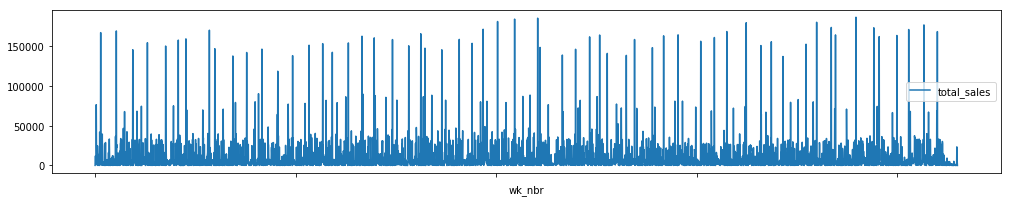

In [155]:
df_1yr = df[(df.wk_nbr>='201801')& (df_1yr.soar_nm == 'GROCERY & HOUSEHOLD')].sort_values('wk_nbr').reset_index(drop=True)
df_1yr.plot(x='wk_nbr', y='total_sales',kind='line',figsize=(17,3))